In [ ]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Conv1D, GlobalMaxPooling1D,Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainname = "train.tsv"
evlname = "dev.tsv"
testname = "test.tsv"
trainset = pd.read_csv("/content/drive/MyDrive/dataset/CoLA/"+trainname,sep="\t",header = None,error_bad_lines = False).drop_duplicates()
trainset.columns = ["1","2","3","4"]
evlset = pd.read_csv("/content/drive/MyDrive/dataset/CoLA/"+evlname,sep="\t",error_bad_lines = False).drop_duplicates()
evlset.columns = ["1","2","3","4"]
testset = pd.read_csv("/content/drive/MyDrive/dataset/CoLA/"+testname,sep="\t",error_bad_lines = False,quoting = csv.QUOTE_NONE).drop_duplicates()
testset.columns = ["1","2"]
trainset.head(5)

,1,2,3,4
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.
3,gj04,1,NaN,"The more we study verbs, the crazier they get."
4,gj04,1,NaN,Day by day the facts are getting murkier.


In [ ]:
import torch

# 禁用GPU，将所有张量放置在CPU上
device = torch.device("cpu")

In [ ]:
evlset.head(5)

,1,2,3,4
0,gj04,1,NaN,The weights made the rope stretch over the pul...
1,gj04,1,NaN,The mechanical doll wriggled itself loose.
2,cj99,1,NaN,"If you had eaten more, you would want less."
3,cj99,0,*,"As you eat the most, you want the least."
4,cj99,0,*,"The more you would want, the less you would eat."


In [ ]:
testset.head(5)

,1,2
0,0,Bill whistled past the house.
1,1,The car honked its way down the road.
2,2,Bill pushed Harry off the sofa.
3,3,the kittens yawned awake and played.
4,4,"I demand that the more John eats, the more he ..."


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
train_set = trainset[["4","2"]].drop_duplicates()
test_set = evlset[["4","2"]].drop_duplicates()

In [ ]:
train_set.columns = ['verse_text','label']
test_set.columns = ['verse_text','label']
def transtoDict(train_set):
    train_set_bert = []
    ver_text = train_set['verse_text']
    ver_label = train_set['label']
    for text,label in dict(zip(ver_text,ver_label)).items():
        train_set_bert.append({'text':text,
                              'label':label})
    return train_set_bert
train_set_bert = transtoDict(train_set)
test_set_bert = train_set_bert[int(len(train_set_bert)*0.8):len(train_set_bert)]
train_set_bert = train_set_bert[0:int(len(train_set_bert)*0.8)]
test_set_bert_real = transtoDict(test_set)
ver_text = []
ver_label = []
for sample in train_set_bert:
    ver_text.append(sample['text'])
    ver_label.append(sample['label'])
train_text = ver_text
train_label = ver_label
ver_test_text = []
ver_test_label = []
for sample in test_set_bert:
    ver_test_text.append(sample['text'])
    ver_test_label.append(sample['label'])
test_text = ver_test_text
test_label = ver_test_label
test_text_real = []
test_label_real = []
for sample in test_set_bert_real:
    test_text_real.append(sample['text'])
    test_label_real.append(sample['label'])
all_text = train_text + test_text + test_text_real

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts((all_text))
sequences = tokenizer.texts_to_sequences(train_text)
max_length = max(len(sequence) for sequence in sequences)
token_seq = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
test_sequences_real = tokenizer.texts_to_sequences(test_text_real)
test_sequences_real = pad_sequences(test_sequences_real, maxlen=max_length, padding='post')

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_text)
test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion = 'entropy',max_depth = 128,random_state=0)
dtc.fit(token_seq,train_label)
pre_dtc = dtc.predict(test_sequences)
print(classification_report(test_label, pre_dtc))
acc_dtc = accuracy_score(test_label, pre_dtc)
print(f'Accuracy = {acc_dtc}')

prec = precision_score(test_label,pre_dtc, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, pre_dtc, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, pre_dtc, average='macro')
print(f'F1 score (macro average) = {f1}')
print(f'Total example:{len(pre_dtc)}, We have {sum(pre_dtc)} postive examples.')

              precision    recall  f1-score   support

           0       0.32      0.33      0.33       471
           1       0.74      0.74      0.74      1236

    accuracy                           0.62      1707
   macro avg       0.53      0.53      0.53      1707
weighted avg       0.63      0.62      0.63      1707

Accuracy = 0.6244874048037493
Precision (macro average) = 0.5332542975696503
Recall (macro average) = 0.5337280728876795
F1 score (macro average) = 0.5334619859951657
Total example:1707, We have 1225 postive examples.


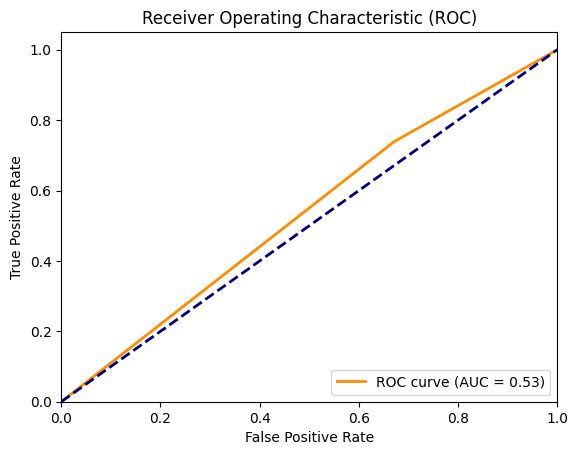

In [ ]:
pre_dtc_prob = dtc.predict_proba(test_sequences)[:,1]
fpr, tpr, _ = roc_curve(test_label, pre_dtc_prob)
roc_auc = roc_auc_score(test_label, pre_dtc_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
####Time cost prediction Dtc####
time_dtc = []
time_test_dtc = []
train_dtc_ans = []
test_dtc_ans = []
for text in token_seq:
    start_time = time.time()
    train_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_dtc.append(time.time() - start_time)
print(f'Completes processing {len(token_seq)} samples.Cost time: {sum(time_dtc)}')
for text in test_sequences:
    start_time = time.time()
    test_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_test_dtc.append(time.time() - start_time)
print(f'Completes processing {len(test_sequences)} samples.Cost time: {sum(time_test_dtc)}')

Completes processing 6825 samples.Cost time: 2.491175889968872
Completes processing 1707 samples.Cost time: 0.5822083950042725


In [ ]:
real_dtc_test = dtc.predict(test_sequences_real)

In [ ]:
max_depth_list = [4,8,10,20,30,50,75,100,200,300,500]
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr_dtc = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_dtc.fit(token_seq,time_dtc)
    time_predict_dtc = dtr_dtc.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_dtc - time_test_dtc)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr_dtc = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr_dtc.fit(token_seq,time_dtc)
time_predict_dtc = dtr_dtc.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_dtc,
                         'Truth':time_test_dtc})
print(sum(time_predict_dtc))
time_list.head(10)

4
0.6135287728525076


,Pre,Truth
0,0.000454,0.013269
1,0.002178,0.000458
2,0.000454,0.000266
3,0.000330,0.000253
4,0.000159,0.000232
5,0.000330,0.000251
6,0.000330,0.000222
7,0.000330,0.000221
8,0.000330,0.000226
9,0.000330,0.000237


In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
model_new = AutoModelForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D",num_labels = 2)
tokenizer_pre = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
def creatDataset(train_data,tensor_return):
    input_ids_list = []
    attention_mask_list = []
    labels = []
    for sample in train_data:
        encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
        input_ids_list.append(encoded_inputs['input_ids'].squeeze())
        attention_mask_list.append(encoded_inputs['attention_mask'].squeeze())
        labels.append(sample['label'])
    print(f'Completes, totally {len(train_data)} samples proceeded.')
    input_ids_tensor = torch.stack(input_ids_list)
    attention_mask_tensor = torch.stack(attention_mask_list)
    labels_tensor = torch.tensor(labels)
    train_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    if tensor_return:
        return train_loader,input_ids_tensor,attention_mask_tensor,labels_tensor
    else:
        return train_loader
train_loader = creatDataset(train_set_bert,False)
test_loader,test_input,test_am,test_l= creatDataset(test_set_bert,True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Completes, totally 6825 samples proceeded.
Completes, totally 1707 samples proceeded.


In [ ]:
device = 'cpu'

In [ ]:
# 定义损失函数和优化器
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_new.parameters(), lr=2e-5)

# 开始训练
model_new.train()
for param in model_new.bert.parameters():
    param.requires_grad = True

for epoch in range(15):
    start_time = time.time()
    for batch in train_loader:
        inputs, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model_new(input_ids=inputs, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch + 1} completes, cost time: {time.time()-start_time}')

Epoch 1 completes, cost time: 96.21771788597107
Epoch 2 completes, cost time: 95.57070255279541
Epoch 3 completes, cost time: 106.4447762966156
Epoch 4 completes, cost time: 96.90690326690674
Epoch 5 completes, cost time: 93.01745247840881
Epoch 6 completes, cost time: 99.0363085269928
Epoch 7 completes, cost time: 105.2124285697937
Epoch 8 completes, cost time: 97.27438592910767
Epoch 9 completes, cost time: 95.45479679107666
Epoch 10 completes, cost time: 95.34005951881409
Epoch 11 completes, cost time: 100.78429317474365
Epoch 12 completes, cost time: 96.7407443523407
Epoch 13 completes, cost time: 97.23587679862976
Epoch 14 completes, cost time: 98.55788540840149
Epoch 15 completes, cost time: 96.95953679084778


In [ ]:
model_new.save_pretrained('./dataset')
tokenizer_pre.save_pretrained('./dataset')

('./dataset\\tokenizer_config.json',
 './dataset\\special_tokens_map.json',
 './dataset\\vocab.txt',
 './dataset\\added_tokens.json',
 './dataset\\tokenizer.json')

In [ ]:
model_new = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/dataset')
tokenizer_pre = AutoTokenizer.from_pretrained('/content/drive/MyDrive/dataset')

In [ ]:
def predict_nn(trained_model, test_input,test_am):
    start_time = time.time()
    # Switch off dropout
    trained_model.eval()

    # Pass the required items from the dataset to the model
    output = trained_model(input_ids=test_input,attention_mask=test_am)

    # the output dictionary contains logits, which are the unnormalised scores for each class for each example:
    pred_labs = np.argmax(output["logits"].detach().numpy(), axis=1)
    return pred_labs


In [ ]:
def predict_prob(trained_model, test_input,test_am):
    start_time = time.time()
    # Switch off dropout
    trained_model.eval()

    # Pass the required items from the dataset to the model
    output = trained_model(input_ids=test_input,attention_mask=test_am)

    # the output dictionary contains logits, which are the unnormalised scores for each class for each example:
    return output

In [ ]:
predictions = predict_nn(model_new,test_input,test_am)

In [ ]:
acc_tbert = accuracy_score(test_l.detach().numpy(), predictions)
print(f'Accuracy = {acc_tbert}')

prec = precision_score(test_l.detach().numpy(), predictions, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_l.detach().numpy(), predictions, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_l.detach().numpy(), predictions, average='macro')
print(f'F1 score (macro average) = {f1}')
print(classification_report(test_l.detach().numpy(), predictions))

Accuracy = 0.6942003514938488
Precision (macro average) = 0.5903570003988832
Recall (macro average) = 0.5700405046070125
F1 score (macro average) = 0.5731616886252329
              precision    recall  f1-score   support

           0       0.42      0.29      0.35       471
           1       0.76      0.85      0.80      1236

    accuracy                           0.69      1707
   macro avg       0.59      0.57      0.57      1707
weighted avg       0.67      0.69      0.68      1707



In [ ]:
##Time cost calculation Bert##
import tqdm
####TinyBert#####
time_Bert = []
train_bert_ans = []
start_time = time.time()
print(f'Totally {len(train_set_bert)} samples.')
for sample in train_set_bert:
    encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
    ids_tensor=encoded_inputs['input_ids']
    am_tensor=encoded_inputs['attention_mask']
    model_new.to('cpu')
    predictions = predict_nn(model_new,ids_tensor,am_tensor)
    train_bert_ans.append(predictions)
    time_Bert.append((time.time()-start_time))
    start_time = time.time()
print(f'Completes.Cost time: {sum(time_Bert)}')

Totally 6825 samples.
Completes.Cost time: 153.04698848724365


In [ ]:
test_time_Bert = []
test_bert_ans = []
start_time = time.time()
print(f'Totally {len(test_set_bert)} samples.')
for sample in test_set_bert:
    encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
    ids_tensor=encoded_inputs['input_ids']
    am_tensor=encoded_inputs['attention_mask']
    model_new.to('cpu')
    predictions = predict_nn(model_new,ids_tensor,am_tensor)
    test_bert_ans.append(predictions)
    test_time_Bert.append((time.time()-start_time))
    start_time = time.time()
print(f'Completes.Cost time: {sum(test_time_Bert)}')

Totally 1707 samples.
Completes.Cost time: 36.916831493377686


In [ ]:
max_depth_list = [4,8,10,20,30,50,75,100,200,300,500]
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr.fit(token_seq,time_Bert)
    time_predict_bert = dtr.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_bert - test_time_Bert)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr.fit(token_seq,time_Bert)
time_predict_bert = dtr.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_bert,
                         'Truth':test_time_Bert})
print(sum(time_predict_bert))

4
37.988212251292815


In [ ]:
import warnings
warnings.filterwarnings('ignore')
knn_model = KNeighborsClassifier(8)
knn_model.fit(token_seq,train_label)
y_pred = knn_model.predict(test_sequences)

In [ ]:
acc_knn = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_knn}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

Accuracy = 0.6508494434680726
Precision (macro average) = 0.5289627612636463
Recall (macro average) = 0.5236792200028858
F1 score (macro average) = 0.5225004505722267
              precision    recall  f1-score   support

           0       0.32      0.24      0.27       471
           1       0.74      0.81      0.77      1236

    accuracy                           0.65      1707
   macro avg       0.53      0.52      0.52      1707
weighted avg       0.62      0.65      0.63      1707



In [ ]:
##Time cost calculation Knn##
time_K = []
train_ans_knn = []
test_ans_knn = []
start_time = time.time()
print(f'Totally {len(train_text)} samples.')
for text_seq in token_seq:
    pre_knn = knn_model.predict(np.expand_dims(text_seq,0))
    time_K.append(time.time()-start_time)
    start_time = time.time()
    train_ans_knn.append(pre_knn)
print(f'Completes.Cost time: {sum(time_K)}')
time_test_K = []
start_time = time.time()
print(f'Totally {len(test_text)} samples.')
for text_seq in test_sequences:
    pre_knn = knn_model.predict(np.expand_dims(text_seq,0))
    time_test_K.append(time.time()-start_time)
    start_time = time.time()
    test_ans_knn.append(pre_knn)
print(f'Completes.Cost time: {sum(time_test_K)}')

Totally 6825 samples.
Completes.Cost time: 17.907899856567383
Totally 1707 samples.
Completes.Cost time: 3.4430739879608154


In [ ]:
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr_knn = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_knn.fit(token_seq,time_K)
    time_predict_knn = dtr_knn.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_knn - time_test_K)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr_knn = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr_knn.fit(token_seq,time_K)
time_predict_knn = dtr_knn.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_knn,
                         'Truth':time_test_K})
print(sum(time_predict_knn))

4
4.566776021563643


In [ ]:
#####Accuracy Predicator######
def acclist(ans,truth):
    truth_list = []
    for a,b in zip(ans,truth):
        if a !=b:
            truth_list.append(0)
        else:
            truth_list.append(1)
    return truth_list
acclist_knn = acclist(train_ans_knn,train_label)
acclist_bert = acclist(train_bert_ans,train_label)
acclist_knn_test = acclist(test_ans_knn,test_label)
acclist_bert_test = acclist(test_bert_ans,test_label)
depth_list = np.linspace(1,20,20,dtype = int)
best_depth_knn = 1
best_depth_bert = 1
acc_knn = 0
acc_bert = 0
for i in depth_list:
    acc_pre_knn = KNeighborsClassifier(i)
    acc_pre_bert = KNeighborsClassifier(i)
    acc_pre_knn.fit(token_seq,acclist_knn)
    acc_pre_bert.fit(token_seq,acclist_bert)
    acc_ans_knn = acc_pre_knn.predict_proba(test_sequences)[:,1]
    acc_ans_bert = acc_pre_bert.predict_proba(test_sequences)[:,1]
    temp_knn = roc_auc_score(acclist_knn_test, acc_ans_knn)
    temp_bert = roc_auc_score(acclist_bert_test, acc_ans_bert)
    best_depth_knn = (i if temp_knn < acc_knn else best_depth_knn)
    acc_knn = temp_knn
    best_depth_bert =( i if temp_bert < acc_bert else best_depth_bert)
    acc_bert = temp_bert
print(best_depth_knn)
print(best_depth_bert)

19
19


In [ ]:
acclist_dtc = acclist(test_dtc_ans,test_label)
acclist_dtc_test = acclist(real_dtc_test,test_label_real)
for i in depth_list:
    acc_pre_dtc = KNeighborsClassifier(i)
    acc_pre_dtc.fit(test_sequences,acclist_dtc)
    acc_ans_dtc = acc_pre_dtc.predict_proba(test_sequences_real)[:,1]
    temp_dtc = roc_auc_score(acclist_dtc_test, acc_ans_dtc)
    best_depth_dtc = (i if temp_dtc < acc_dtc else best_depth_dtc)
print(best_depth_dtc)
acc_pre_dtc = KNeighborsClassifier(best_depth_dtc)
acc_pre_dtc.fit(test_sequences,acclist_dtc)
acc_ans_dtc = acc_pre_dtc.predict(test_sequences)
print(classification_report(acclist_dtc, acc_ans_dtc))
acc_ans_dtc = acc_pre_dtc.predict_proba(test_sequences)[:,1]

20
              precision    recall  f1-score   support

           0       0.53      0.40      0.45       641
           1       0.68      0.79      0.73      1066

    accuracy                           0.64      1707
   macro avg       0.61      0.59      0.59      1707
weighted avg       0.63      0.64      0.63      1707



In [ ]:
acc_pre_knn = KNeighborsClassifier(best_depth_knn)
acc_pre_bert = KNeighborsClassifier(best_depth_bert)
acc_pre_knn.fit(token_seq,acclist_knn)
acc_pre_bert.fit(token_seq,acclist_bert)
acc_ans_knn = acc_pre_knn.predict(test_sequences)
acc_ans_bert = acc_pre_bert.predict(test_sequences)
print(classification_report(acclist_knn_test, acc_ans_knn))
print(classification_report(acclist_bert_test, acc_ans_bert))

              precision    recall  f1-score   support

           0       0.54      0.04      0.07       596
           1       0.66      0.98      0.79      1111

    accuracy                           0.65      1707
   macro avg       0.60      0.51      0.43      1707
weighted avg       0.61      0.65      0.54      1707

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       522
           1       0.69      1.00      0.82      1185

    accuracy                           0.69      1707
   macro avg       0.35      0.50      0.41      1707
weighted avg       0.48      0.69      0.57      1707



In [ ]:
####Check area#####
check_list_knn = pd.DataFrame({'Pred':test_ans_knn,
                              'Truth':test_label,
                              'Acc':acclist_knn_test,
                              'Acc Pre':acc_ans_knn})
check_list_knn.head(10)
check_list_bert = pd.DataFrame({'Pred':test_bert_ans,
                              'Truth':test_label,
                              'Acc':acclist_bert_test,
                              'Acc Pre':acc_ans_bert})
check_list_bert.head(10)

,Pred,Truth,Acc,Acc Pre
0,[1],0,0,1
1,[1],0,0,1
2,[1],0,0,1
3,[1],0,0,1
4,[0],0,1,1
5,[1],1,1,1
6,[1],1,1,1
7,[0],1,0,1
8,[1],1,1,1
9,[1],1,1,1


In [ ]:
def utility(accw,acc,costw,cost):
    return (acc*accw - cost*costw)

In [ ]:
accw = 0.1
cost_list = np.append(np.linspace(1e-1,1,50),np.linspace(1,10,50))
#cost_list = np.append(cost_list,np.linspace(1,10,50))
cost_list[0] = 0
acc_list = []
time_list = []
model_list = []
F1_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert:
        time_knn_use = dtr_knn.predict(np.expand_dims(test_sequences[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences[count],0))
        acc_knn = acc_pre_knn.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        uti_knn = utility(accw,acc_knn,costw,time_knn_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_knn > uti_bert):
            result_pre.append(knn_model.predict(np.expand_dims(test_sequences[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

,Cost,Time,Acc,F1,Model
0,0.000000,55.261911,0.694200,0.573162,1703
1,0.118367,52.652711,0.693615,0.571971,1655
2,0.136735,52.246832,0.694200,0.572416,1653
3,0.155102,53.461808,0.694786,0.572862,1652
4,0.173469,53.055677,0.694200,0.572416,1649
5,0.191837,53.855394,0.694200,0.572416,1649
6,0.210204,49.886981,0.693615,0.571971,1647
7,0.228571,50.862361,0.693029,0.571526,1641
8,0.246939,52.914645,0.693615,0.571222,1631
9,0.265306,51.669351,0.693615,0.568182,1540


In [ ]:
#acc_time.head(len(cost_list))
acc_time.head(150)

,Cost,Time,Acc,F1,Model
0,0.000000,55.261911,0.694200,0.573162,1703
1,0.118367,52.652711,0.693615,0.571971,1655
2,0.136735,52.246832,0.694200,0.572416,1653
3,0.155102,53.461808,0.694786,0.572862,1652
4,0.173469,53.055677,0.694200,0.572416,1649
...,...,...,...,...,...
95,9.265306,4.297465,0.650849,0.522500,0
96,9.448980,4.330431,0.650849,0.522500,0
97,9.632653,4.414519,0.650849,0.522500,0
98,9.816327,3.399107,0.650849,0.522500,0


In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)

[0.6942003514938488, 0.6936145284124194, 0.6947861745752782, 0.69302870533099, 0.6959578207381371, 0.6953719976567077, 0.6977152899824253, 0.6983011130638547, 0.6988869361452841, 0.7012302284710018, 0.7018160515524312, 0.7024018746338606, 0.70298769771529, 0.7041593438781488, 0.7006444053895724, 0.700058582308143, 0.6994727592267135, 0.690099589923843, 0.6889279437609842, 0.6836555360281195, 0.677211482132396, 0.6690099589923842, 0.6596367896895138, 0.6567076742823668, 0.6543643819566491, 0.651435266549502, 0.6508494434680726]


<function matplotlib.pyplot.legend(*args, **kwargs)>

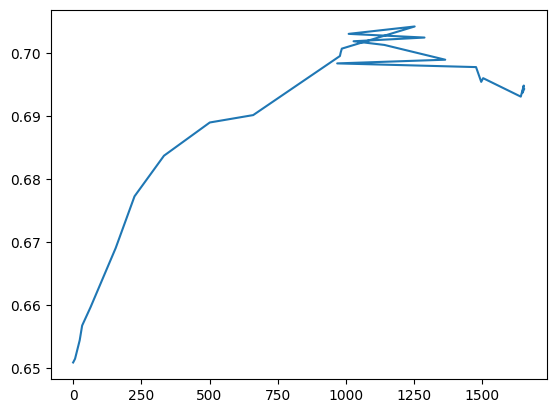

In [ ]:
import matplotlib.pyplot as plt
plt.plot(uni_model,uni_acc)
plt.legend

In [ ]:
acc_list = []
time_list = []
F1_list = []
model_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert_real:
        time_knn_use = dtr_knn.predict(np.expand_dims(test_sequences_real[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences_real[count],0))
        acc_knn = acc_pre_knn.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        uti_knn = utility(accw,acc_knn,costw,time_knn_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_knn > uti_bert):
            result_pre.append(knn_model.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label_real, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label_real, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

,Cost,Time,Acc,F1,Model
0,0.000000,40.956117,0.684971,0.599735,1035
1,0.118367,33.015891,0.681118,0.591112,1009
2,0.136735,30.545429,0.682081,0.591874,1008
3,0.155102,30.743389,0.682081,0.591874,1008
4,0.173469,31.911572,0.683044,0.592637,1007
5,0.191837,31.586016,0.683044,0.592637,1006
6,0.210204,30.492753,0.682081,0.591874,1004
7,0.228571,31.821768,0.683044,0.593583,1002
8,0.246939,31.274466,0.683044,0.593583,996
9,0.265306,29.635542,0.686898,0.595695,965


In [ ]:
print(len(test_label_real))

1038


[0.684971098265896, 0.6811175337186898, 0.6820809248554913, 0.6830443159922929, 0.6868978805394991, 0.6859344894026975, 0.6897880539499036, 0.6936416184971098, 0.6888246628131022, 0.6878612716763006, 0.6840077071290944, 0.6801541425818882, 0.6791907514450867, 0.6917148362235067, 0.6676300578034682, 0.6599229287090559, 0.6579961464354528, 0.651252408477842, 0.6483622350674374, 0.6464354527938343, 0.640655105973025, 0.638728323699422, 0.6377649325626205]
    Model Selection  Accuracy  Time cost
0             938.0  0.684971  28.438526
1             593.0  0.681118  18.325731
2             598.0  0.682081  19.157763
3             608.0  0.683044  20.384541
4             785.0  0.686898  25.162732
5             946.0  0.685934  28.824312
6             833.0  0.689788  26.320310
7             862.0  0.693642  26.928444
8             796.0  0.688825  25.708983
9             312.0  0.687861  11.537164
10            611.0  0.684008  18.541970
11            639.0  0.680154  19.889882
12        

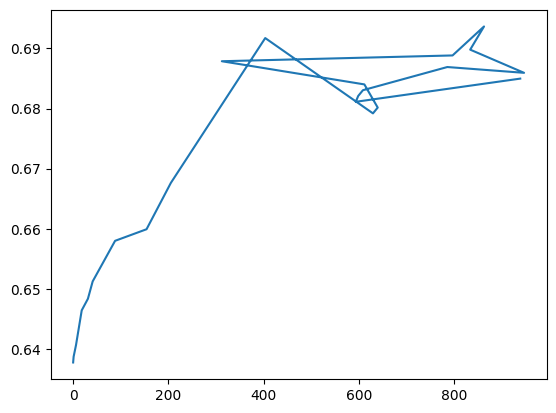

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(np.mean(acc_time[acc_time['Time'] == mintime]['Model']))
print(uni_acc)
plt.plot(uni_model,uni_acc)
plt.show
print(pd.DataFrame({'Model Selection': uni_model,
                    'Accuracy':uni_acc,
                    'Time cost':uni_time}))

In [ ]:
####Naive Bayes####
from sklearn.model_selection import GridSearchCV
MNB = MultinomialNB()
MNB.fit(token_seq,train_label)
y_pred = MNB.predict(test_sequences)
acc_nb = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_nb}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

Accuracy = 0.46104276508494435
Precision (macro average) = 0.49921955854159245
Recall (macro average) = 0.49905180054830667
F1 score (macro average) = 0.4504493155286806
              precision    recall  f1-score   support

           0       0.28      0.58      0.37       471
           1       0.72      0.41      0.53      1236

    accuracy                           0.46      1707
   macro avg       0.50      0.50      0.45      1707
weighted avg       0.60      0.46      0.48      1707



In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(token_seq,train_label)
y_pred = lr.predict(test_sequences)
acc_lr = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_lr}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

Accuracy = 0.7234915055653193
Precision (macro average) = 0.361957796014068
Recall (macro average) = 0.49959546925566345
F1 score (macro average) = 0.41978246091094495
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       471
           1       0.72      1.00      0.84      1236

    accuracy                           0.72      1707
   macro avg       0.36      0.50      0.42      1707
weighted avg       0.52      0.72      0.61      1707



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tf_train = tfidf_vectorizer.fit_transform(train_text)
tf_test = tfidf_vectorizer.transform(test_text)
MNB = MultinomialNB()
MNB.fit(tf_train,train_label)
y_pred = MNB.predict(tf_test)
acc_nb = accuracy_score(test_label, y_pred)
print(f'Accuracy = {acc_nb}')

prec = precision_score(test_label, y_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_label, y_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_label, y_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

# We can get all of these with a per-class breakdown using classification_report:
print(classification_report(test_label, y_pred))

Accuracy = 0.7199765670767428
Precision (macro average) = 0.4772500227045682
Recall (macro average) = 0.4991394059324305
F1 score (macro average) = 0.42462838123713087
              precision    recall  f1-score   support

           0       0.23      0.01      0.01       471
           1       0.72      0.99      0.84      1236

    accuracy                           0.72      1707
   macro avg       0.48      0.50      0.42      1707
weighted avg       0.59      0.72      0.61      1707



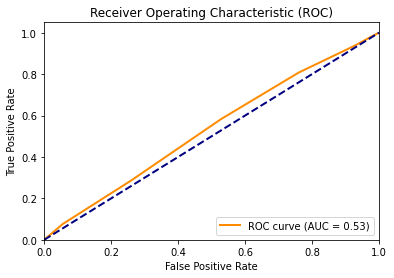

In [ ]:
pre_knn_prob = knn_model.predict_proba(test_sequences)[:,1]
fpr, tpr, _ = roc_curve(test_label, pre_knn_prob)
roc_auc = roc_auc_score(test_label, pre_knn_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
pre_bert_prob = predict_prob(model_new,test_input,test_am)["logits"].detach().numpy()

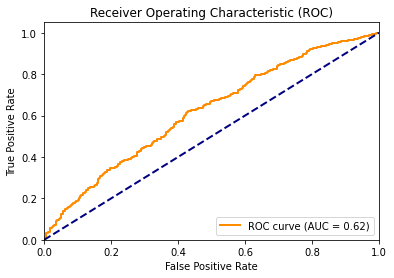

In [ ]:
pre_bert_probs = []
for i in pre_bert_prob:
    pre_bert_probs.append(i[1])
fpr, tpr, _ = roc_curve(test_label, pre_bert_probs)
roc_auc = roc_auc_score(test_label, pre_bert_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
####Time cost prediction Dtc####
time_dtc = []
time_test_dtc = []
train_dtc_ans = []
test_dtc_ans = []
for text in token_seq:
    start_time = time.time()
    train_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_dtc.append(time.time() - start_time)
print(f'Completes processing {len(token_seq)} samples.Cost time: {sum(time_dtc)}')
for text in test_sequences:
    start_time = time.time()
    test_dtc_ans.append(dtc.predict(np.expand_dims(text,0)))
    time_test_dtc.append(time.time() - start_time)
print(f'Completes processing {len(test_sequences)} samples.Cost time: {sum(time_test_dtc)}')

Completes processing 6825 samples.Cost time: 0.9235565662384033
Completes processing 1707 samples.Cost time: 0.23363590240478516


In [ ]:
max_depth_list = [4,8,10,20,30,50,75,100,200,300,500]
best_depth = 0
best_loss = 99999
for depth in max_depth_list:
    dtr_dtc = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dtr_dtc.fit(token_seq,time_dtc)
    time_predict_dtc = dtr_dtc.predict(test_sequences)
    loss = sum(abs(np.array(time_predict_dtc - test_time_Bert)**2))
    if best_loss>loss:
        best_loss = loss
        best_depth = depth
print(best_depth)
dtr_dtc = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dtr_dtc.fit(token_seq,time_dtc)
time_predict_dtc = dtr_dtc.predict(test_sequences)
time_list = pd.DataFrame({'Pre':time_predict_dtc,
                         'Truth':time_test_dtc})
print(sum(time_predict_dtc))
time_list.head(10)

50
0.2520636320114136


,Pre,Truth
0,0.000113,0.000239
1,0.000119,0.000153
2,0.000124,0.000137
3,0.000128,0.000127
4,0.000155,0.000124
5,0.000148,0.000135
6,0.000119,0.000123
7,0.000169,0.000122
8,0.000124,0.000144
9,0.000119,0.000135


In [ ]:
accw = 0.1
cost_list = np.append(np.linspace(1e-1,1,50),np.linspace(1,10,50))
#cost_list = np.append(cost_list,np.linspace(1,10,50))
cost_list[0] = 0
acc_list = []
time_list = []
model_list = []
F1_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert:
        time_dtc_use = dtr_dtc.predict(np.expand_dims(test_sequences[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences[count],0))
        acc_dtc = acc_pre_dtc.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences[count],0))[:, 1]
        uti_dtc = utility(accw,acc_dtc,costw,time_dtc_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_dtc > uti_bert):
            result_pre.append(dtc.predict(np.expand_dims(test_sequences[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

,Cost,Time,Acc,F1,Model
0,0.000000,50.868583,0.695372,0.575536,1698
1,0.118367,52.602207,0.695372,0.575536,1696
2,0.136735,55.737243,0.695372,0.575536,1696
3,0.155102,55.953436,0.694786,0.575088,1693
4,0.173469,55.242212,0.694786,0.575088,1690
5,0.191837,52.813210,0.695958,0.578176,1680
6,0.210204,50.788870,0.695958,0.578176,1676
7,0.228571,52.000768,0.698887,0.581159,1668
8,0.246939,52.982815,0.698887,0.581159,1664
9,0.265306,52.296314,0.698887,0.581159,1664


In [ ]:
acc_time.head(100)

,Cost,Time,Acc,F1,Model
0,0.000000,50.868583,0.695372,0.575536,1698
1,0.118367,52.602207,0.695372,0.575536,1696
2,0.136735,55.737243,0.695372,0.575536,1696
3,0.155102,55.953436,0.694786,0.575088,1693
4,0.173469,55.242212,0.694786,0.575088,1690
...,...,...,...,...,...
95,9.265306,0.410581,0.624487,0.533462,0
96,9.448980,0.423512,0.624487,0.533462,0
97,9.632653,0.398768,0.624487,0.533462,0
98,9.816327,0.436293,0.624487,0.533462,0


[0.6953719976567077, 0.6947861745752782, 0.6959578207381371, 0.6988869361452841, 0.6977152899824253, 0.6983011130638547, 0.7006444053895724, 0.7018160515524312, 0.7035735207967194, 0.70298769771529, 0.7047451669595782, 0.705916813122437, 0.7076742823667252, 0.7065026362038664, 0.7082601054481547, 0.7070884592852958, 0.7088459285295841, 0.7100175746924429, 0.7094317516110135, 0.7111892208553017, 0.7106033977738723, 0.690099589923843, 0.6824838898652607, 0.6760398359695372, 0.6625659050966608, 0.6467486818980668, 0.632688927943761, 0.6303456356180434, 0.6256590509666081, 0.6250732278851787, 0.6244874048037493]


<function matplotlib.pyplot.show(close=None, block=None)>

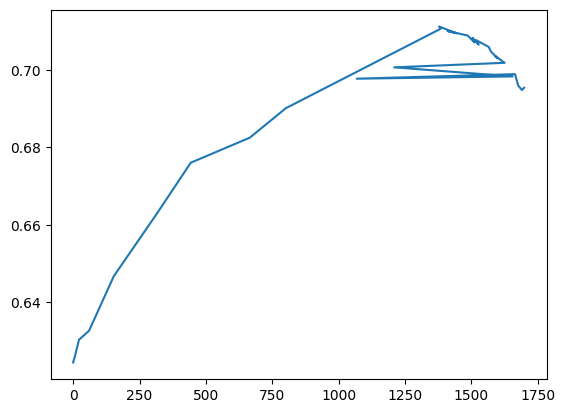

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(acc_time[acc_time['Time'] == mintime]['Model'])
print(uni_acc)
plt.plot(uni_model,uni_acc)
plt.show

In [ ]:
print(len(test_set_bert))

1707


In [ ]:
accw = 0.1
cost_list = np.append(np.linspace(1e-1,1,50),np.linspace(1,10,50))
#cost_list = np.append(cost_list,np.linspace(1,10,50))
cost_list[0] = 0
acc_list = []
time_list = []
F1_list = []
model_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert_real:
        time_dtc_use = dtr_dtc.predict(np.expand_dims(test_sequences_real[count],0))
        time_bert_use = dtr.predict(np.expand_dims(test_sequences_real[count],0))
        acc_dtc = acc_pre_dtc.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        acc_tbert = acc_pre_bert.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        uti_dtc = utility(accw,acc_dtc,costw,time_dtc_use)
        uti_bert = utility(accw,acc_tbert,costw,time_bert_use)
        start_time= time.time()
        if(uti_dtc > uti_bert):
            result_pre.append(dtc.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(0)
        else:
            encoded_inputs = tokenizer_pre(sample['text'], padding='max_length',max_length=max_length, truncation=True, return_tensors='pt')
            ids_tensor=encoded_inputs['input_ids']
            am_tensor=encoded_inputs['attention_mask']
            model_new.to('cpu')
            result_pre.append(predict_nn(model_new,ids_tensor,am_tensor))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label_real, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label_real, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

,Cost,Time,Acc,F1,Model
0,0.000000,34.305760,0.684008,0.598963,1034
1,0.118367,31.211074,0.684008,0.598963,1034
2,0.136735,34.111714,0.684008,0.598963,1034
3,0.155102,33.797188,0.685934,0.600507,1032
4,0.173469,31.231719,0.685934,0.600507,1032
5,0.191837,32.378278,0.686898,0.602183,1029
6,0.210204,37.647765,0.686898,0.601280,1021
7,0.228571,31.185295,0.686898,0.601280,1018
8,0.246939,33.436267,0.686898,0.601280,1018
9,0.265306,32.375022,0.685934,0.600507,1015


[0.6840077071290944, 0.6859344894026975, 0.6868978805394991, 0.684971098265896, 0.6830443159922929, 0.6801541425818882, 0.6791907514450867, 0.6782273603082851, 0.6753371868978806, 0.6772639691714836, 0.6734104046242775, 0.6657032755298651, 0.6579961464354528, 0.6377649325626205, 0.6339113680154143, 0.6136801541425819, 0.617533718689788, 0.6146435452793835, 0.6059730250481695, 0.6069364161849711]
    Model Selection  Accuracy  Time cost        F1
0             979.0  0.684008  30.059481  0.597638
1            1007.0  0.685934  30.790149  0.601071
2            1002.0  0.686898  30.783181  0.601796
3             991.0  0.684971  31.067104  0.598368
4             946.0  0.683044  30.262597  0.596373
5             934.0  0.680154  35.887047  0.594073
6             912.0  0.679191  28.659849  0.593002
7             906.0  0.678227  28.123980  0.592085
8             893.0  0.675337  27.856234  0.587494
9             872.0  0.677264  27.200774  0.590250
10            824.0  0.673410  25.426297

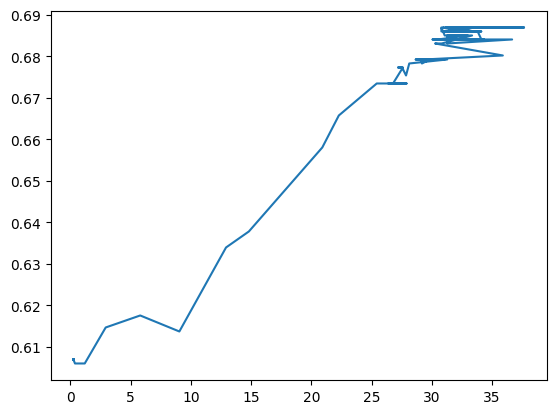

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(min(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(acc_time[acc_time['Time'] == max(temp_time)]['Cost'])
for mintime in uni_time:
    uni_model.append(np.mean(acc_time[acc_time['Time'] == mintime]['Model']))
print(uni_acc)
plt.plot(time_list,acc_list)
plt.show
temp_frame = {'Model Selection': uni_model,
                    'Accuracy':uni_acc,
                    'Time cost':uni_time,
              'F1':uni_F1}
print(pd.DataFrame(temp_frame))

In [ ]:
accw = 0.1
cost_list = np.append(np.linspace(1e-1,1,50),np.linspace(1,10,50))
#cost_list = np.append(cost_list,np.linspace(1,10,50))
cost_list[0] = 0
acc_list = []
time_list = []
F1_list = []
model_list = []
for costw in cost_list:
    time_total = []
    model_select = []
    result_pre = []
    count = 0
    for sample in test_set_bert_real:
        time_knn_use = dtr_knn.predict(np.expand_dims(test_sequences_real[count],0))
        time_dtc_use = dtr_dtc.predict(np.expand_dims(test_sequences_real[count],0))
        acc_knn = acc_pre_knn.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        acc_dtc = acc_pre_dtc.predict_proba(np.expand_dims(test_sequences_real[count],0))[:, 1]
        uti_knn = utility(accw,acc_knn,costw,time_knn_use)
        uti_dtc = utility(accw,acc_dtc,costw,time_dtc_use)
        start_time= time.time()
        if(uti_knn > uti_dtc):
            result_pre.append(knn_model.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(0)
        else:
            result_pre.append(dtc.predict(np.expand_dims(test_sequences_real[count],0)))
            model_select.append(1)
        time_total.append(time.time()-start_time)
        count = count+1
    acc = accuracy_score(test_label_real, result_pre)
    acc_list.append(acc)
    F1_list.append(f1_score(test_label_real, result_pre, average='macro'))
    time_list.append(sum(time_total))
    model_list.append(sum(model_select))
acc_time = pd.DataFrame({'Cost':cost_list,
                        'Time':time_list,
                        'Acc':acc_list,
                         'F1':F1_list,
                        'Model':model_list})
acc_time.head(50)

,Cost,Time,Acc,F1,Model
0,0.000000,6.903836,0.641618,0.513940,249
1,0.118367,5.328310,0.641618,0.513940,249
2,0.136735,5.938005,0.641618,0.513940,249
3,0.155102,4.292133,0.641618,0.513940,249
4,0.173469,4.472628,0.641618,0.513940,249
5,0.191837,3.006934,0.641618,0.513940,249
6,0.210204,1.803224,0.641618,0.513940,249
7,0.228571,2.315944,0.641618,0.513940,249
8,0.246939,2.345680,0.641618,0.513940,249
9,0.265306,1.756038,0.641618,0.513940,249


[0.6416184971098265, 0.6425818882466281, 0.640655105973025, 0.649325626204239, 0.6464354527938343, 0.6435452793834296, 0.6454720616570327, 0.6396917148362236, 0.638728323699422, 0.6368015414258189, 0.6339113680154143, 0.6329479768786127, 0.6319845857418112, 0.6310211946050096, 0.6358381502890174, 0.6348747591522158, 0.630057803468208, 0.6290944123314065, 0.628131021194605, 0.6271676300578035]


<function matplotlib.pyplot.show(close=None, block=None)>

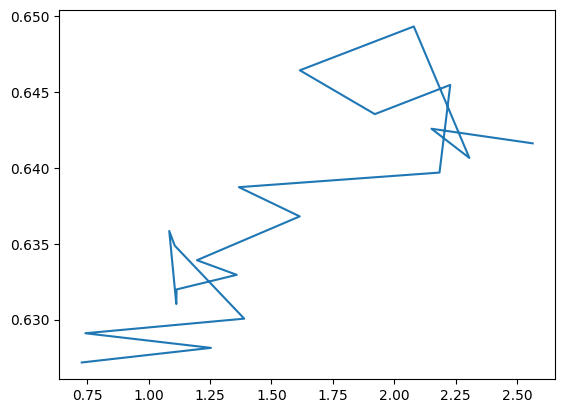

In [ ]:
uni_time = []
uni_acc = []
uni_F1 = []
uni_cost = []
uni_model = []
for acc in acc_list:
    if acc not in uni_acc:
        uni_acc.append(acc)
for acc in uni_acc:
    temp_time = acc_time[acc_time['Acc'] == acc]['Time']
    temp_F1 = acc_time[acc_time['Acc'] == acc]['F1']
    uni_time.append(np.mean(temp_time))
    uni_F1.append(np.mean(temp_F1))
    uni_cost.append(np.mean(acc_time[acc_time['Time'] == max(temp_time)]['Cost']))
for mintime in uni_time:
    uni_model.append(np.mean(acc_time[acc_time['Time'] == mintime]['Model']))
print(uni_acc)
llll = []
for i in range(100):
 llll.append(1707)
plt.plot(uni_time,uni_acc)
plt.show

In [ ]:
temp_frame = {
                    'Accuracy':uni_acc,
                    'Time cost':uni_time,
              'F1':uni_F1}
print(pd.DataFrame(temp_frame))

    Accuracy  Time cost        F1
0   0.641618   2.563833  0.514481
1   0.642582   2.151603  0.518302
2   0.640655   2.306020  0.514578
3   0.649326   2.079711  0.525661
4   0.646435   1.615610  0.522386
5   0.643545   1.920995  0.523363
6   0.645472   2.228116  0.526688
7   0.639692   2.184359  0.525029
8   0.638728   1.367328  0.524745
9   0.636802   1.615120  0.527222
10  0.633911   1.196579  0.526091
11  0.632948   1.358644  0.526200
12  0.631985   1.113559  0.526779
13  0.631021   1.112462  0.527889
14  0.635838   1.083768  0.528645
15  0.634875   1.106037  0.530727
16  0.630058   1.389055  0.529432
17  0.629094   0.742070  0.531888
18  0.628131   1.253500  0.531196
19  0.627168   0.727436  0.531529
